<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Olympia_Hertel_estimation_uni_ensemble_testset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Olympia_Hertel_estimation_RepVGG-A2**

---



In [1]:
from __future__ import print_function, division
!pip install --q torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import re
import time
import os
import copy
import statistics
import math
from decimal import Decimal, ROUND_HALF_UP
import shutil
import codecs
from scipy import stats
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install --q pingouin
import pingouin as pg

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

random_seed = 3 #shuffleのシード

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 61 kB 450 kB/s 
     |████████████████████████████████| 185 kB 7.5 MB/s 
     |████████████████████████████████| 9.9 MB 69.1 MB/s 
Sun Nov 13 16:18:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A

#**Set Parameters**

In [2]:
path = '/content/drive/MyDrive/Deep_learning/Olympia_dataset'
os.chdir(path)

# grav or cont, age, and sex
#NUM_CLASSES = 3

# contains train, val
#DATASET_PATH = r"./dataset_500px"
AREA = ["half", "periocular", "eye"]
DATASET_PATH_0 = f"./dataset_250px_uni_{AREA[0]}"
DATASET_PATH_1 = f"./dataset_250px_uni_{AREA[1]}"
DATASET_PATH_2 = f"./dataset_250px_uni_{AREA[2]}"
PARENT_PATHS = [DATASET_PATH_0, DATASET_PATH_1, DATASET_PATH_2]
#TRAIN_FOLDER_NAME = "train"
#VAL_FOLDER_NAME = "val"
#EFFICIENT_NET_NAME = "RepVGG-A2-train"
MODEL_PATH = "./RepVGG-A2-train.pth"
CSV_PATH = "./Hertel_unilateral.csv"
#OPTIMIZER_PATH = "./optimizer_multi.pth"
#SEX_DICT_PATH = "gender_json"
#AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
#CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16

# transforms param　　左右分けているのでflipはしない
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
ROTATION_DEGREES = 3
TRAIN_CROP_SCALE =(0.75,1.0)

VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                #transforms.RandomRotation(ROTATION_DEGREES),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])]) 

#**5-Foldに分割**

In [3]:
def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_ids(path_list):
    #id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    id_list = [os.path.basename(name).split(".")[0] for name in path_list]
    return(id_list)

def extract_patient_number(path_list):
    patient_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(patient_list)


path_list = make_path_list(PARENT_PATHS[1])

#それぞれの項目（path, classes, ID）をリスト化
id = extract_ids(path_list)
patient = extract_patient_number(id)

print("id_num: {}".format(len(id)))
print("patient_num: {}".format(len(patient)))

print(len(path_list))

id_num: 1959
patient_num: 1959
1959


In [4]:
id_list_0 = extract_ids(make_path_list(DATASET_PATH_0))
id_list_1 = extract_ids(make_path_list(DATASET_PATH_1))
id_list_2 = extract_ids(make_path_list(DATASET_PATH_2))
common_id = set(id_list_0) & set(id_list_1) & set(id_list_2)
common_patient = list([id.split("_")[0] for id in common_id])

path_list_0 = [f"{DATASET_PATH_0}/{id}.JPG" for id in common_id]    
path_list_1 = [f"{DATASET_PATH_1}/{id}.JPG" for id in common_id]    
path_list_2 = [f"{DATASET_PATH_2}/{id}.JPG" for id in common_id]    
path_list_list = [path_list_0, path_list_1, path_list_2]

print(f"common_ids: {len(common_id)}")
print(f"common_patients: {len(common_patient)}")
print(f"{path_list_0[20]}")
print(f"{path_list_1[20]}")
print(f"{path_list_2[20]}")

common_ids: 1959
common_patients: 1959
./dataset_250px_uni_half/19_L.JPG
./dataset_250px_uni_periocular/19_L.JPG
./dataset_250px_uni_eye/19_L.JPG


In [5]:
#Group Shuffle Split ＋　Group K-foldを用いてデータセット分け(idxを抜き出し)
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

#fold数だけ空のリストを作成
num_folds = 5
train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]
train_idx, val_idx =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]
test_idx = []
test_set, remain_set = [], []

#remain:test = 1:9で分割
X = np.ones(len(common_id))
y = np.ones(len(common_id))
groups = common_patient
gss = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=random_seed)
for remain_idxs, test_idxs in gss.split(X, y, groups):
    pass

test_idx = [idx for idx in test_idxs]
# test_set = [path_list[idxs] for idxs in test_idxs]

remain_patients = [patient[idxs] for idxs in remain_idxs]
# remain_set = [path_list[idxs] for idxs in remain_idxs]

X = np.ones(len(remain_idxs))
y = np.ones(len(remain_idxs))
gkf = GroupKFold(n_splits=num_folds)
i=0
for train_idxs, val_idxs in gkf.split(X, y, groups=remain_patients):
    for idx in train_idxs:
        # train_set[i].append(remain_set[idx])
        train_idx[i].append(idx)
    for idx in val_idxs:
        # val_set[i].append(remain_set[idx])
        val_idx[i].append(idx)
    i+=1

print("train_dataset: {}".format(len(train_idx[0])))
print("val_dataset: {}".format(len(val_idx[0])))
print("test_dataset: {}".format(len(test_idx)))
# print("")
# print("extracted_id (example): {}".format(extract_ids(test_set)[0]))

train_dataset: 1410
val_dataset: 353
test_dataset: 196


#**Create Datasets**

In [6]:
class Create_Datasets(Dataset):
     
    def __init__(self, image_path_list_list, idxs, csv_path, transform):
        self.transform = transform
        self.path_list_list = path_list_list
        self.idxs = idxs
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path)
        df = self.df

        k=0
        for idx in idxs:
            path_0, path_1, path_2 = path_list_list[0][idx], path_list_list[1][idx], path_list_list[2][idx]
            base_name = os.path.splitext(os.path.basename(path_0))[0] #フォルダより画像番号を抜き出す
            hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
            self.item_paths.append([path_0, path_1, path_2, hertel]) #[path, hertel]の組み合わせをリストに追加する
            item_paths = self.item_paths
 
    def __len__(self):
        return len(self.item_paths)
     
    def __getitem__(self, index):
        # [tensor[path0, path1, path2], hertel_value]
        def tensor_img(image_path):
            pilr_image = Image.open(image_path).convert("RGB")
            tensor_image = self.transform(pilr_image).float()
            return tensor_image
        tensor_image_0 = tensor_img(self.item_paths[index][0]) 
        tensor_image_1 = tensor_img(self.item_paths[index][1])      
        tensor_image_2 = tensor_img(self.item_paths[index][2])      
        tensor_image = torch.stack([tensor_image_0, tensor_image_1, tensor_image_2])
        #tensor_image = tensor_image_0
        hertel = self.item_paths[index][3]
        target= torch.tensor([hertel]).float()
        return  tensor_image, target

train_dataset = Create_Datasets(path_list_list, train_idx[0], CSV_PATH, train_data_transforms)
val_dataset = Create_Datasets(path_list_list, val_idx[0], CSV_PATH, val_data_transforms)
test_dataset = Create_Datasets(path_list_list, test_idx, CSV_PATH, val_data_transforms) 
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 1)

print('train_dataset_size: ' +str(len(train_dataset)))
print('val_dataset_size: ' +str(len(val_dataset)))
print('test_dataset_size: ' +str(len(test_dataset)))

train_dataset_size: 1410
val_dataset_size: 353
test_dataset_size: 196


#**Test with early-stopping**

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


#1つずつ解析するバージョン
def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device, area_num, alpha=0):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor[:,area_num])  #16,3,3,224,224 --> 16,3,224,224 (バッチサイズの次の次元でスライスすることによりtensorを取り出す)
            # calculate the loss
            loss = loss_func(output, target)

            ################
            ##l2_normalization##
            ################
            l2 = torch.tensor(0., requires_grad=True)
            for w in model.parameters():
                l2 = l2 + torch.norm(w)**2
            loss = loss + alpha*l2

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor[:,area_num])
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)

        
        #Scheduler step for SGD
        #scheduler.step() #val_lossが下がらなければ減衰
        

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#**define RepVGG-A2**

In [8]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
        self.fc = nn.Linear(in_features=1408, out_features=1) #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x) #dropoutを1層追加
        x = self.fc(x)
        return x

#**ConvNetの調整**

In [ ]:
model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load(MODEL_PATH)) 
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# !pip install ranger_adabelief
# from ranger_adabelief import RangerAdaBelief
# optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

# Observe that all parameters are being optimized
# optimizer_ft =  optim.AdaBound(
#     model_ft.parameters(),
#     lr= 1e-3,
#     betas= (0.9, 0.999),
#     final_lr = 0.1,
#     gamma=1e-3,
#     eps= 1e-8,
#     weight_decay=5e-4,
#     amsbound=False,
# )

#**モデルのトレーニング**

In [ ]:
"""
area_num
1: half 
2: periocular
3: eye
データセットからそれぞれの画像を読みこんでトレーニング
"""

for area_num in [0,2]:
    model_ft = create_RepVGG_A2(deploy=False)
    model_ft.load_state_dict(torch.load(MODEL_PATH)) 
    model_ft = mod_RepVGG()
    model_ft = model_ft.to(device)
    loss_func = nn.MSELoss()
    optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

    model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device, area_num=area_num)

    #save the model
    PATH = f"./models_Herter_estimation/{AREA[area_num]}_RepVGGA2.pth"
    torch.save(model_ft.state_dict(), PATH)

#**Draw Learning Curves**

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss', color="#377eb8")
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss', color="#ff7f00")

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 10.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

In [ ]:
"""
##########################
# Load model 飛ばして下さい
##########################
area_num
1: half 
2: periocular
3: eye
"""
area_num = 1


model_ft = create_RepVGG_A2(deploy=False)
model_ft = mod_RepVGG()
model_ft.to(device)

#ネットワークの読み込み
PATH = f"./models_Herter_estimation/{AREA[area_num]}_RepVGGA2.pth"
model_ft.load_state_dict(torch.load(PATH))

In [12]:
#evaluation using validation dataset

test_dataset = Create_Datasets(path_list_list, test_idx, CSV_PATH, val_data_transforms) 
test_loader = DataLoader(test_dataset, batch_size = 1)


def my_round(x, d=2):
    p = Decimal(str(x)).quantize(Decimal(str(1/10**d)), rounding=ROUND_HALF_UP)
    p = float(p)
    return p


model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:  
      target = target.view(len(target), 1)         
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor[:,area_num]) #dim0はbach_size、dim1がarea_num

      outputs.append(output[0].item())      
      targets.append(target[0].item())
      #print(f"estimate: {my_round(output[0].item())} mm, target: {target[0].item()} mm")

      errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))
print('')


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))


AveError: -0.2800481708682313
StdError: 1.190435633596737
AveAbsError: 0.8439131318306436
StdAbsError: 0.8832465896326539

Corrected_AveAbsError: 0.7959983174575462
Corrected_StdAbsError: 0.883331408508461
Round_Corrected_AveAbsError: 0.7956632653061224
Round_Corrected_StdAbsError: 0.8835395418008711


(10.0, 24.0)

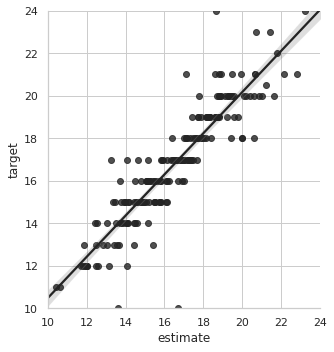

In [13]:
#Draw Graphs（もともとの散布図
df = pd.DataFrame({'estimate':outputs, 'target':targets})

sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


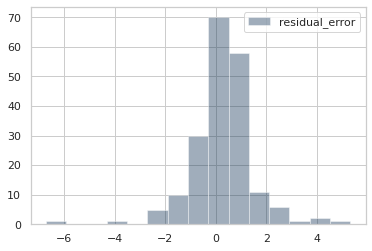

In [14]:
#Draw histogram
sns.distplot(
    df['target']-df['estimate'], bins=15, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示

In [97]:
df

,estimate,target
0,17.052931,17.0
1,19.918318,19.0
2,21.616062,18.0
3,14.647196,14.0
4,19.210493,20.0
...,...,...
191,17.081892,17.0
192,14.618496,14.0
193,14.313133,14.0
194,19.244455,19.0


In [15]:
total = len(df)
within1 = sum((i <= 1 and i >= -1 for i in df['estimate']-df['target']))
within2 = sum((i <= 2 and i >= -2 for i in df['estimate']-df['target']))
over2 = sum((i > 2 or i < -2 for i in df['estimate']-df['target']))

print(f'-1<Error<1: {within1}, ({my_round(within1/total*100)}%)')
print(f'-2<Error<2: {within1}, ({my_round(within2/total*100)}%)')
print(f'Error over 2: {within1}, ({my_round(over2/total*100)}%)')

TP, FP, TN, FN = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,0]>=18 and df.iloc[i,1]>= 18:
        TP += 1
    if df.iloc[i,0]<18 and df.iloc[i,1]>= 18:
        FN += 1
    if df.iloc[i,0]>=18 and df.iloc[i,1]< 18:
        FP += 1 
    if df.iloc[i,0]<18 and df.iloc[i,1]< 18:
        TN += 1     

print('')
print('Hertel 18mm以上の検出精度')
print('TP: '+str(TP))
print('FP: '+str(FP))
print('FN: '+str(FN))
print('TN: '+str(TN))
print('Sensitivity: '+str(TP/(TP+FN)))
print('Specificity: '+str(TN/(FP+TN)))
print('Positive predictive value: '+str(TP/(TP+FP)))
print('Negative predictive value: '+str(TN/(TN+FN)))


okpositive, minogashi, oknegative, kajyou = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,0]>=16 and df.iloc[i,1]> 18:
        okpositive += 1
    if df.iloc[i,0]<16 and df.iloc[i,1]>= 18:
        minogashi += 1
    if df.iloc[i,0]>=18 and df.iloc[i,1]<= 16:
        kajyou += 1 
    if df.iloc[i,0]<18 and df.iloc[i,1]<= 16:
        oknegative += 1     

print('')
print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')



-1<Error<1: 138, (70.41%)
-2<Error<2: 138, (91.33%)
Error over 2: 138, (8.67%)

Hertel 18mm以上の検出精度
TP: 59
FP: 0
FN: 20
TN: 117
Sensitivity: 0.7468354430379747
Specificity: 1.0
Positive predictive value: 1.0
Negative predictive value: 0.8540145985401459

推測18mm以上だが実は16mm未満(過剰): 0例
推測16mm未満だが実は18mm以上（見逃がし）: 0例


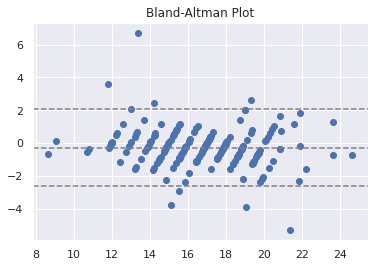

In [102]:
#Bland-Altman-Plot 

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

###**平均値、線形近似による補正**

In [15]:
#線形近似式算出
from sklearn import linear_model

estimate = df.loc[:,'estimate']
target = df.loc[:,'target']
clf = linear_model.LinearRegression()

# 説明変数xに "x1"のデータを使用
x = np.array([estimate]).T

# 目的変数yに "x2"のデータを使用
y = target.values

# 予測モデルを作成（単回帰）
clf.fit(x, y)

# パラメータ（回帰係数、切片）を抽出
[a] = clf.coef_
b = clf.intercept_

# パラメータの表示
print("回帰係数:", a)
print("切片:", b)
print("決定係数:", clf.score(x, y))

#平均値により補正した値
df['Corrected_estimate_1']=0
for i in range(len(df)):
    df.iloc[i,2] = corrected_output[i]

#回帰直線により補正した値
df['Corrected_estimate_2']=0
for i in range(len(df)):
    df.iloc[i,3] = df.iloc[i,0]*a+b

#残差
df['Residual_error_1']=0
for i in range(len(df)):
    df.iloc[i,4] = df.iloc[i,2]-df.iloc[i,1]

#残差
df['Residual_error_2']=0
for i in range(len(df)):
    df.iloc[i,5] = df.iloc[i,3]-df.iloc[i,1]


回帰係数: 0.9605424949327473
切片: 0.6495924021508088
決定係数: 0.8499442075877566


In [22]:
print(df)

      estimate  target  Corrected_estimate_1  Corrected_estimate_2  \
0    17.052931    17.0             17.038316             17.029657   
1    19.918318    19.0             19.903703             19.781983   
2    21.616062    18.0             21.601447             21.412739   
3    14.647196    14.0             14.632581             14.718846   
4    19.210493    20.0             19.195878             19.102087   
..         ...     ...                   ...                   ...   
191  17.081892    17.0             17.067277             17.057476   
192  14.618496    14.0             14.603881             14.691279   
193  14.313133    14.0             14.298518             14.397965   
194  19.244455    19.0             19.229840             19.134710   
195  15.081180    10.0             15.066564             15.135706   

     Residual_error_1  Residual_error_2  
0            0.038316          0.029657  
1            0.903703          0.781983  
2            3.601447          3.

In [ ]:
#平均近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_1'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_1', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

corrected_AbsError = [abs(i) for i in df['Residual_error_1']]
print('AveError: '+str(statistics.mean(df['Residual_error_1'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_1'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


print('')
print('-1<Error<1: '+ str(sum((i < 1 and i > -1 for i in df['Residual_error_2']))))
print('-2<Error<2: '+ str(sum((i < 2 and i > -2 for i in df['Residual_error_2']))))
print('Error<=-2: ' +  str(sum((i <= -2 for i in df['Residual_error_2']))))
print('Error>=2: ' +  str(sum((i >= 2 for i in df['Residual_error_2']))))


TP, FP, TN, FN = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=18 and df.iloc[i,2]>= 18:
        TP += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]>= 18:
        FP += 1
    if df.iloc[i,1]>=18 and df.iloc[i,2]< 18:
        FN += 1 
    if df.iloc[i,1]<18 and df.iloc[i,2]< 18:
        TN += 1     

print('')
print('Hertel 18mm以上の検出精度')
print('TP: '+str(TP))
print('FP: '+str(FP))
print('FN: '+str(FN))
print('TN: '+str(TN))
print('Sensitivity: '+str(TP/(TP+FN)))
print('Specificity: '+str(TN/(FP+TN)))
print('Positive predictive value: '+str(TP/(TP+FP)))
print('Negative predictive value: '+str(TN/(TN+FN)))


okpositive, minogashi, oknegative, kajyou = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=16 and df.iloc[i,2]> 18:
        okpositive += 1
    if df.iloc[i,1]<16 and df.iloc[i,2]>= 18:
        kajyou += 1
    if df.iloc[i,1]>=18 and df.iloc[i,2]<= 16:
        minogashi += 1 
    if df.iloc[i,1]<18 and df.iloc[i,2]<= 16:
        oknegative += 1     

print('')
print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')


In [ ]:
#Bland-Altman-Plot using corrected value (平均値により補正)

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')


corrected_estimate = df.loc[:,'Corrected_estimate_1']
target = df.loc[:,'target']

bland_altman_plot(corrected_estimate, target)
plt.title('Bland-Altman Plot')
plt.show()


In [ ]:
#線形近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_2'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_2', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

corrected_AbsError = [abs(i) for i in df['Residual_error_2']]
print('AveError: '+str(statistics.mean(df['Residual_error_2'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_2'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

print('')
print('-1<Error<1: '+ str(sum((i < 1 and i > -1 for i in df['Residual_error_2']))))
print('-2<Error<2: '+ str(sum((i < 2 and i > -2 for i in df['Residual_error_2']))))
print('Error<=-2: ' +  str(sum((i <= -2 for i in df['Residual_error_2']))))
print('Error>=2: ' +  str(sum((i >= 2 for i in df['Residual_error_2']))))


TP, FP, TN, FN = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=18 and df.iloc[i,3]>= 18:
        TP += 1
    if df.iloc[i,1]<18 and df.iloc[i,3]>= 18:
        FP += 1
    if df.iloc[i,1]>=18 and df.iloc[i,3]< 18:
        FN += 1 
    if df.iloc[i,1]<18 and df.iloc[i,3]< 18:
        TN += 1     

print('')
print('Hertel 18mm以上の検出精度')
print('TP: '+str(TP))
print('FP: '+str(FP))
print('FN: '+str(FN))
print('TN: '+str(TN))
print('Sensitivity: '+str(TP/(TP+FN)))
print('Specificity: '+str(TN/(FP+TN)))
print('Positive predictive value: '+str(TP/(TP+FP)))
print('Negative predictive value: '+str(TN/(TN+FN)))


okpositive, minogashi, oknegative, kajyou = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=16 and df.iloc[i,3]> 18:
        okpositive += 1
    if df.iloc[i,1]<16 and df.iloc[i,3]>= 18:
        kajyou += 1
    if df.iloc[i,1]>=18 and df.iloc[i,3]<= 16:
        minogashi += 1 
    if df.iloc[i,1]<18 and df.iloc[i,3]<= 16:
        oknegative += 1     

print('')
print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')

In [ ]:
#Bland-Altman-Plot using corrected value (線形近似により補正)

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')


corrected_estimate = df.loc[:,'Corrected_estimate_2']
target = df.loc[:,'target']

bland_altman_plot(corrected_estimate, target)
plt.title('Bland-Altman Plot')
plt.show()


#**Ensemble learning (Stacking)**

In [42]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


#1つずつ解析するバージョン
def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device, alpha=0):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor[:,0], image_tensor[:,1], image_tensor[:,2])  #16,3,3,224,224 --> 16,3,224,224 (バッチサイズの次の次元でスライスすることによりtensorを取り出す)
            # calculate the loss
            loss = loss_func(output, target)

            ################
            ##l2_normalization##
            ################
            l2 = torch.tensor(0., requires_grad=True)
            for w in model.parameters():
                l2 = l2 + torch.norm(w)**2
            loss = loss + alpha*l2

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor[:,0], image_tensor[:,1], image_tensor[:,2])
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)

        
        #Scheduler step for SGD
        #scheduler.step() #val_lossが下がらなければ減衰
        

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
"""
##########################
# Load model 
##########################
area_num
1: half 
2: periocular
3: eye
"""

model_ft = create_RepVGG_A2(deploy=False)
model_ft = mod_RepVGG()
model_ft.to(device)

model_ft_half = model_ft
model_ft_periocular = model_ft
model_ft_eye = model_ft

class Ensemble_three(nn.Module):
    def __init__(self):
        super(Ensemble_three, self).__init__()
        self.model_0 = model_ft_half
        self.model_1 = model_ft_periocular
        self.model_2 = model_ft_eye
        self.fc = nn.Linear(in_features=3, out_features=1) #out_featuresを1に

    def forward(self, x0, x1, x2):
        x0 = self.model_0(x0)
        x1 = self.model_1(x1)
        x2 = self.model_2(x2)
        x = torch.cat([x0, x1, x2], dim=1)
        x = self.fc(x)
        return x

In [47]:
model_ft_ensemble = Ensemble_three()
model_ft_ensemble.to(device)
loss_func = nn.MSELoss()
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

def read_path(area_num):
    #ネットワークの読み込み
    PATH = f"./models_Herter_estimation/{AREA[area_num]}_RepVGGA2.pth"
    return PATH

model_ft_half = model_ft.load_state_dict(torch.load(read_path(0)))
model_ft_periocular = model_ft.load_state_dict(torch.load(read_path(1)))
model_ft_eye = model_ft.load_state_dict(torch.load(read_path(2)))

In [58]:
model_ft_ensemble.fc

Linear(in_features=3, out_features=1, bias=True)

In [51]:
model_ft_ensemble

Ensemble_three(
  (model_0): mod_RepVGG(
    (repVGG): Sequential(
      (0): RepVGGBlock(
        (nonlinearity): ReLU()
        (rbr_dense): Sequential(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (rbr_1x1): Sequential(
          (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Sequential(
        (0): RepVGGBlock(
          (nonlinearity): ReLU()
          (rbr_dense): Sequential(
            (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (rbr_1x1): Sequential(
            (conv): Conv2d(64, 96, kernel_size=(1, 1), stride=

In [45]:
model, train_loss, valid_loss = train_model(model_ft_ensemble, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)


KeyboardInterrupt: ignored

#**Automated 5-fold crossvalidation**

In [ ]:
cols = ['target', 'fold0', 'fold1', 'fold2', 'fold3', 'fold4', 'fold0_corrected', 'fold1_corrected', 'fold2_corrected', 'fold3_corrected', 'fold4_corrected',]
df_result = pd.DataFrame(index=[], columns=cols)

cols = ['AveError', 'AveStdError', 'AveAbsError', 'StdAbsError', 'Corrected_AveAbsError', 'Corrected_StdAbsError', 'Round_Corrected_AveAbsError', 'Round_Corrected_StdAbsError']
indices = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']
df_summary = pd.DataFrame(index=indices, columns=cols)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

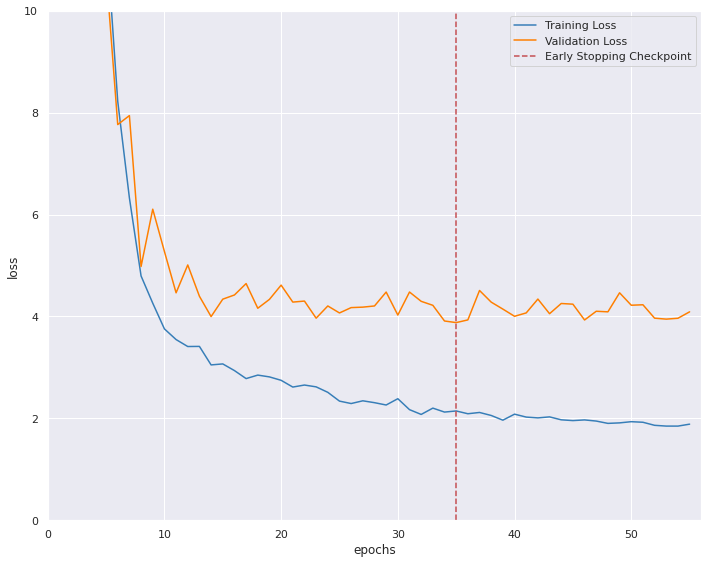

fold 0

--evaluation using val dataset--
AveError: -0.225694713696756
StdError: 1.9608213320883012
AveAbsError: 1.5210658631038145
StdAbsError: 1.255355668032136

Corrected_AveAbsError: 1.5142106697207591
Corrected_StdAbsError: 1.2432636917487554
Round_Corrected_AveAbsError: 1.510928961748634
Round_Corrected_StdAbsError: 1.2921854527330083

--evaluation using test dataset--
AveError: -0.0791924093283859
StdError: 2.0729075471372655
AveAbsError: 1.6632631760017544
StdAbsError: 1.234170098860893

Corrected_AveAbsError: 1.6581944129137935
Corrected_StdAbsError: 1.2384636116828323
Round_Corrected_AveAbsError: 1.6274509803921569
Round_Corrected_StdAbsError: 1.2782497934797619


RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block

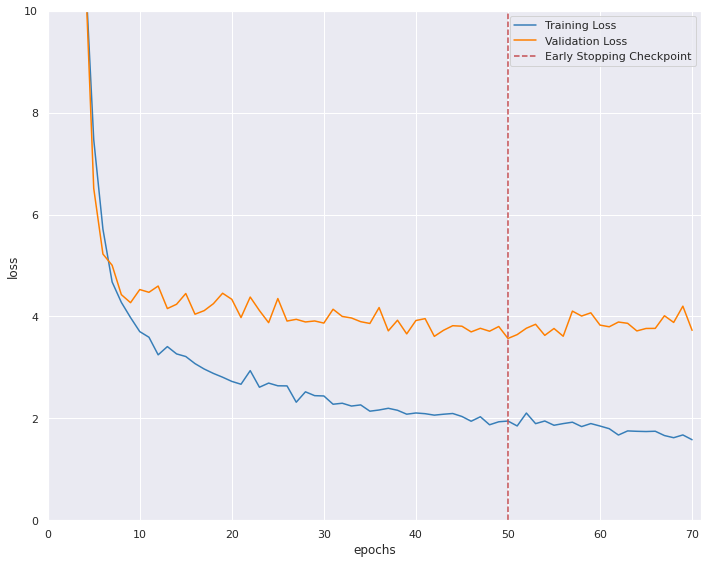

fold 1

--evaluation using val dataset--
AveError: -0.24701529383007945
StdError: 1.8753298701546974
AveAbsError: 1.493303973818086
StdAbsError: 1.1584384390781988

Corrected_AveAbsError: 1.4877990069217482
Corrected_StdAbsError: 1.1389695902977957
Round_Corrected_AveAbsError: 1.4754098360655739
Round_Corrected_StdAbsError: 1.233414559428352

--evaluation using test dataset--
AveError: -0.21065726934694776
StdError: 2.111484542290402
AveAbsError: 1.6592305033814674
StdAbsError: 1.3177080083239239

Corrected_AveAbsError: 1.648861894420549
Corrected_StdAbsError: 1.3138601867219053
Round_Corrected_AveAbsError: 1.607843137254902
Round_Corrected_StdAbsError: 1.3512035339101185


RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Bloc

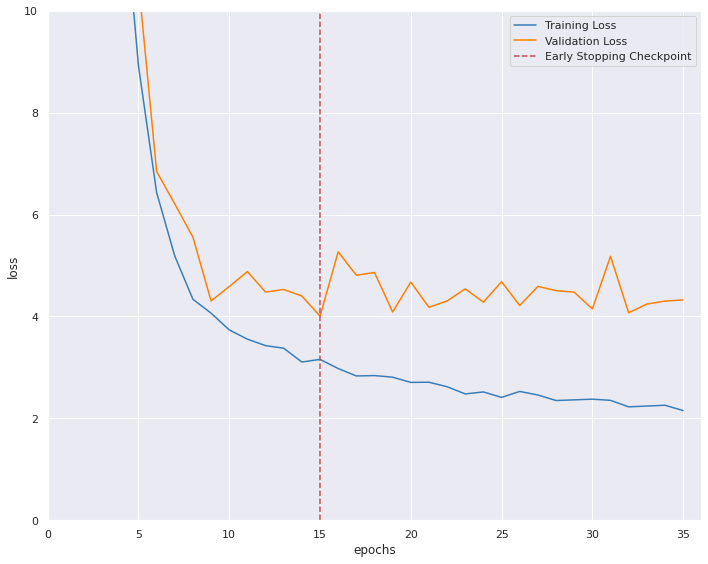

fold 2

--evaluation using val dataset--
AveError: -0.4316610899127898
StdError: 1.9594159466928958
AveAbsError: 1.5802547319339273
StdAbsError: 1.2337365885874485

Corrected_AveAbsError: 1.5309425032097177
Corrected_StdAbsError: 1.2202887262428328
Round_Corrected_AveAbsError: 1.505464480874317
Round_Corrected_StdAbsError: 1.2621888696112604

--evaluation using test dataset--
AveError: -0.09950646699643602
StdError: 2.0443181163998148
AveAbsError: 1.6001104513804119
StdAbsError: 1.2713067445891875

Corrected_AveAbsError: 1.6022522680028863
Corrected_StdAbsError: 1.2646651195319962
Round_Corrected_AveAbsError: 1.5294117647058822
Round_Corrected_StdAbsError: 1.3070923045710245


RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG B

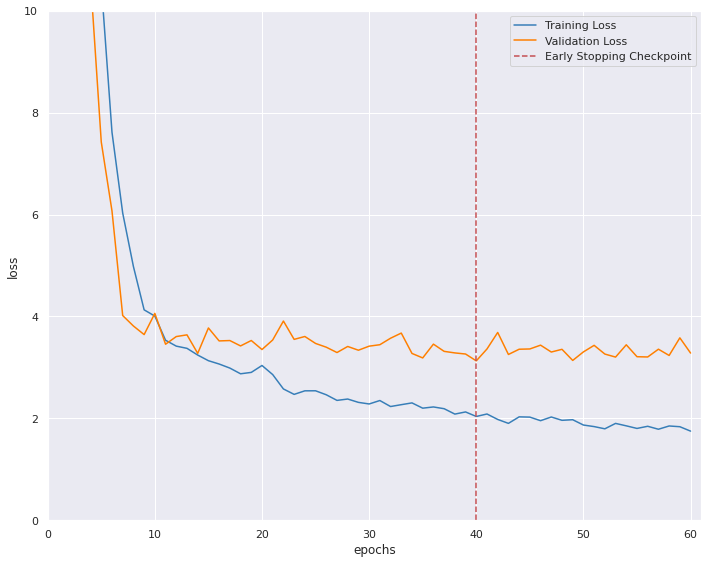

fold 3

--evaluation using val dataset--
AveError: -0.23276089840247982
StdError: 1.7556614545978888
AveAbsError: 1.4153503355432728
StdAbsError: 1.0620585548644277

Corrected_AveAbsError: 1.4020593598422253
Corrected_StdAbsError: 1.0541304578551376
Round_Corrected_AveAbsError: 1.3743169398907105
Round_Corrected_StdAbsError: 1.1247143676787181

--evaluation using test dataset--
AveError: -0.4256068725211948
StdError: 2.0347220230157186
AveAbsError: 1.6231995049644918
StdAbsError: 1.2939750437936017

Corrected_AveAbsError: 1.6017036943974652
Corrected_StdAbsError: 1.2498004953973674
Round_Corrected_AveAbsError: 1.5980392156862746
Round_Corrected_StdAbsError: 1.3187529855428572


RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG 

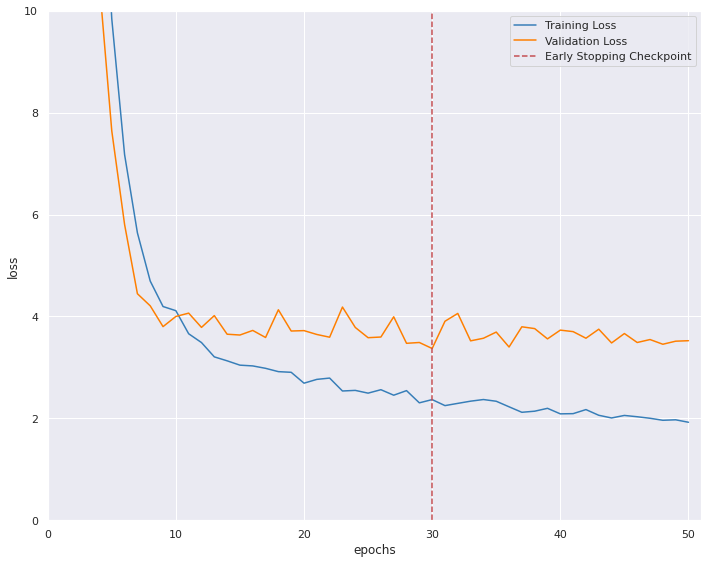

fold 4

--evaluation using val dataset--
AveError: 0.11711168813181448
StdError: 1.8366463313146533
AveAbsError: 1.4347843180645954
StdAbsError: 1.1501067542721912

Corrected_AveAbsError: 1.4307935552570559
Corrected_StdAbsError: 1.1491126843111525
Round_Corrected_AveAbsError: 1.3956043956043955
Round_Corrected_StdAbsError: 1.2140510777453166

--evaluation using test dataset--
AveError: -0.07112759234858494
StdError: 2.0442536200774177
AveAbsError: 1.623007054422416
StdAbsError: 1.239729366839674

Corrected_AveAbsError: 1.6243911390806884
Corrected_StdAbsError: 1.2358511364629787
Round_Corrected_AveAbsError: 1.607843137254902
Round_Corrected_StdAbsError: 1.2915554661224957




In [ ]:
fold_start = 0 #スタートするfold
dst_result_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel_estimation_result.csv"
dst_summary_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel_estimation_summary.csv"

#四捨五入のモジュール
def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p

for fold in range(fold_start,5,1):    
    ###############
    ##Define model ##
    ###############

    model_ft = create_RepVGG_A2(deploy=False)
    model_ft.load_state_dict(torch.load(MODEL_PATH)) 
    model_ft = mod_RepVGG()
    #GPU使用
    model_ft = model_ft.to(device)
    #損失関数を定義
    loss_func = nn.MSELoss()
    #Optimizer
    optimizer_ft = torch.optim.AdamW(model_ft.parameters(), lr=1e-5)
    alpha = 1e-6 #l2_normalization

    #################
    ## select dataset ##
    ################
    train_dataset = Create_Datasets(train_set[fold], CSV_PATH, train_data_transforms)
    val_dataset = Create_Datasets(val_set[fold], CSV_PATH, val_data_transforms)
    test_dataset = Create_Datasets(test_set, CSV_PATH, val_data_transforms) 
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
    val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size = 1)

    #################
    ## train model ##
    #################
    model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE,optimizer_ft, PATIENCE, EPOCH, device, alpha)

    ####################
    ## Draw learning curve ##
    ####################

    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss', color="#377eb8")
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss', color="#ff7f00")

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 10.0) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot(Hertel)_fold'+str(fold)+'.png', bbox_inches='tight', dpi=350)


    ###########################
    ## eval using validation dataset ##
    ###########################

    #evaluation using validation dataset (1枚ずつevalする)
    val_dataset = Create_Datasets(val_set[fold], CSV_PATH, val_data_transforms)
    val_loader = DataLoader(val_dataset, batch_size = 1)

    model_ft.eval() # prep model for evaluation

    outputs,targets,errors =[], [], []
    for image_tensor, target in val_loader:  
          target = target.view(len(target), 1)         
          image_tensor = image_tensor.to(device)
          target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model_ft(image_tensor)

          outputs.append(output[0].item())      
          targets.append(target[0].item())
          errors.append(output[0].item()-target[0].item())

    AbsError = [abs(i) for i in errors]

    print('fold '+str(fold))
    print('')
    print('--evaluation using val dataset--')
    print('AveError: '+str(statistics.mean(errors)))
    print('StdError: '+str(statistics.stdev(errors)))
    print('AveAbsError: '+str(statistics.mean(AbsError)))
    print('StdAbsError: '+str(statistics.stdev(AbsError)))
    print('')


    #平均からの差分を補正
    corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
    corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
    corrected_AbsError = [abs(i) for i in corrected_error]

    round_output = [my_round(i) for i in outputs]
    round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

    print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
    print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))
    print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
    print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))
    print('')
    ###########################
    ## eval using test dataset ##
    ###########################

    model_ft.eval() # prep model for evaluation

    outputs,targets,errors =[], [], []
    for image_tensor, target in test_loader:  
          target = target.view(len(target), 1)         
          image_tensor = image_tensor.to(device)
          target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model_ft(image_tensor)

          outputs.append(output[0].item())      
          targets.append(target[0].item())
          errors.append(output[0].item()-target[0].item())

    AbsError = [abs(i) for i in errors]

    
    print('--evaluation using test dataset--')
    print('AveError: '+str(statistics.mean(errors)))
    print('StdError: '+str(statistics.stdev(errors)))
    print('AveAbsError: '+str(statistics.mean(AbsError)))
    print('StdAbsError: '+str(statistics.stdev(AbsError)))
    print('')


    #平均からの差分を補正
    corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
    corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
    corrected_AbsError = [abs(i) for i in corrected_error]

    round_output = [my_round(i) for i in outputs]
    round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

    print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
    print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))
    print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
    print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))
    print('')
    print('')

    #結果をdataframeに書き込む
    df_result['target'] = targets
    df_result['fold'+str(fold)] = outputs
    df_result['fold'+str(fold)+'_corrected'] = corrected_output
    df_summary.iloc[fold, 0] = statistics.mean(errors)
    df_summary.iloc[fold, 1] = statistics.stdev(errors)
    df_summary.iloc[fold, 2] = statistics.mean(AbsError)
    df_summary.iloc[fold, 3] = statistics.stdev(AbsError)
    df_summary.iloc[fold, 4] = statistics.mean(corrected_AbsError)
    df_summary.iloc[fold, 5] = statistics.stdev(corrected_AbsError)
    df_summary.iloc[fold, 6] = statistics.mean(round_corrected_AbsError)
    df_summary.iloc[fold, 7] = statistics.stdev(round_corrected_AbsError)

    df_result.to_csv(dst_result_path,index=False)
    df_summary.to_csv(dst_summary_path)



In [ ]:
dst_result_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel_estimation_result_1.csv"

#Open reslut_csv
with codecs.open(dst_result_path, "r", "Shift-JIS", "ignore") as file:
    df_result = pd.read_csv(file, index_col=None, header=0)

df_result

,target,fold0,fold1,fold2,fold3,fold4,fold0_corrected,fold1_corrected,fold2_corrected,fold3_corrected,fold4_corrected
0,16.0,18.274897,18.086258,16.982693,16.731331,18.360825,17.683797,18.048479,17.346565,16.704272,18.388139
1,16.0,18.240702,16.648167,17.850836,19.017797,18.382151,17.649602,16.610387,18.214708,18.990738,18.409465
2,16.0,18.401655,16.097504,17.015856,16.246473,16.902615,17.810555,16.059725,17.379728,16.219414,16.929929
3,16.0,16.841370,16.170847,17.116571,17.318340,19.125807,16.250270,16.133068,17.480444,17.291281,19.153122
4,21.0,19.725548,21.173748,20.488394,20.001635,20.520454,19.134448,21.135969,20.852266,19.974575,20.547769
...,...,...,...,...,...,...,...,...,...,...,...
199,17.0,14.232739,13.812715,14.326204,13.889405,14.692945,13.641640,13.774935,14.690077,13.862346,14.720260
200,19.0,21.097057,21.475121,20.992577,21.097054,20.442337,20.505957,21.437341,21.356449,21.069994,20.469652
201,19.0,20.500013,18.138063,18.657246,19.152702,19.862629,19.908913,18.100284,19.021118,19.125643,19.889944
202,15.0,17.755945,17.409885,16.379116,16.741234,16.965052,17.164845,17.372106,16.742989,16.714175,16.992366


In [ ]:
#5-foldのICC(2,1)とp-valueを算出
target = df_result["target"]
fold0 = df_result["fold0_corrected"]
fold1 = df_result["fold1_corrected"]
fold2 = df_result["fold2_corrected"]
fold3 = df_result["fold3_corrected"]
fold4 = df_result["fold4_corrected"]

ICC_list, pval_list , ave_list, std_list, ttest_list= [], [], [], [], []
for fold in [fold0,fold1,fold2,fold3,fold4]:
    ratings = np.concatenate([target,fold])
    raters = ['target'] * len(target) + ['pred'] *len(fold)
    targets = [i for i in range(len(target))]+[i for i in range(len(target))]

    data = pd.DataFrame({'targets':targets, 'raters':raters, 'ratings':ratings})
    icc = pg.intraclass_corr(data=data, targets='targets', 
                            raters='raters', ratings='ratings')
    df_icc = icc.set_index('Type')
    ICC_list.append(df_icc.loc["ICC2","ICC"])
    pval_list.append(df_icc.loc["ICC2","pval"])
    ave_list.append(statistics.mean(fold))
    std_list.append(statistics.stdev(fold))
    ttest_list.append(stats.ttest_rel(target, fold)[1])


print("target: {}±{}".format(statistics.mean(target), statistics.stdev(target)))
print("folds: {}±{}".format(statistics.mean(ave_list), statistics.mean(std_list)))
print("p-value (ttest): {}".format(statistics.mean(ttest_list)))
print("ICC(2,1): {}±{}".format(statistics.mean(ICC_list), statistics.stdev(ICC_list)))
print("p-value (ICC): {}".format(statistics.mean(pval_list)))


target: 16.86519607843137±2.7894442938967283
folds: 16.86519607845098±2.3422292408301435
p-value (ttest): 0.9999999991062075
ICC(2,1): 0.704768158145101±0.030114555646246675
p-value (ICC): 3.4573877614181293e-29


In [ ]:
#calculate residual error
df_result["fold0_residual_error"] = df_result["fold0_corrected"] - df_result["target"]
df_result["fold1_residual_error"] = df_result["fold1_corrected"] - df_result["target"]
df_result["fold2_residual_error"] = df_result["fold2_corrected"] - df_result["target"]
df_result["fold3_residual_error"] = df_result["fold3_corrected"] - df_result["target"]
df_result["fold4_residual_error"] = df_result["fold4_corrected"] - df_result["target"]

under1mm_list, under2mm_list, sensitivity_list, specificity_list = [], [], [], []
k=0
for fold in [fold0, fold1, fold2, fold3, fold4]: 
    print("fold {}".format(k))
    print("")

    ########################
    ##Draw Graphs（散布図)##
    ########################
    df = pd.DataFrame({'estimate':fold, 'target':target})

    sns.set_style('whitegrid')
    sns.set_palette('gray')
    sns.lmplot(x='estimate', y='target', data=df)
    plt.xlim(10,24)
    plt.ylim(10,24)
    plt.title('Scatter Plot')
    plt.show()

    ###########################################
    ##Bland-Altman-Plot using corrected value##
    ###########################################
    def bland_altman_plot(data1, data2, *args, **kwargs):
        data1     = np.asarray(data1)
        data2     = np.asarray(data2)
        mean      = np.mean([data1, data2], axis=0)
        diff      = data1 - data2                   # Difference between data1 and data2
        md        = np.mean(diff)                   # Mean of the difference
        sd        = np.std(diff, axis=0)            # Standard deviation of the difference
        plt.scatter(mean, diff, *args, **kwargs)
        plt.axhline(md,           color='gray', linestyle='--')
        plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
        plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    corrected_estimate = fold
    target = df.loc[:,'target']

    bland_altman_plot(corrected_estimate, target)
    plt.title('Bland-Altman Plot')
    plt.show()

    ####################
    ## Draw histogram ##
    ####################
    sns.distplot(
    df_result['fold'+str(k)+'_residual_error'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
    )
    plt.legend() # 凡例を表示
    plt.show()   # ヒストグラムを表示


    #Draw Graphs
    sns.set_style('whitegrid')
    sns.set_palette('gray')
    sns.lmplot(x='fold'+str(k)+"_corrected", y='target', data=df_result)
    plt.xlim(10,24)
    plt.ylim(10,24)

    corrected_AbsError = [abs(i) for i in df_result['fold'+str(k)+'_residual_error']]
    print('AveError: '+str(statistics.mean(df_result['fold'+str(k)+'_residual_error'])))
    print('StdError: '+str(statistics.stdev(df_result['fold'+str(k)+'_residual_error'])))
    print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
    print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


    print('')
    print('-1<Error<1: '+ str(sum((i < 1 and i > -1 for i in df_result['fold'+str(k)+'_residual_error']))))
    print('-2<Error<2: '+ str(sum((i < 2 and i > -2 for i in df_result['fold'+str(k)+'_residual_error']))))
    print('Error<=-2: ' +  str(sum((i <= -2 for i in df_result['fold'+str(k)+'_residual_error']))))
    print('Error>=2: ' +  str(sum((i >= 2 for i in df_result['fold'+str(k)+'_residual_error']))))


    TP, FP, TN, FN = 0,0,0,0
    for i in range(len(df_result)):
        if df_result.loc[i,"target"]>=18 and df_result.loc[i,'fold'+str(k)+"_corrected"]>= 18:
            TP += 1
        if df_result.loc[i,"target"]<18 and df_result.loc[i,'fold'+str(k)+"_corrected"]>= 18:
            FP += 1
        if df_result.loc[i,"target"]>=18 and df_result.loc[i,'fold'+str(k)+"_corrected"]< 18:
            FN += 1 
        if df_result.loc[i,"target"]<18 and df_result.loc[i,'fold'+str(k)+"_corrected"]< 18:
            TN += 1     

    print('')
    print('Hertel 18mm以上の検出精度')
    print('TP: '+str(TP))
    print('FP: '+str(FP))
    print('FN: '+str(FN))
    print('TN: '+str(TN))
    print('Sensitivity: '+str(TP/(TP+FN)))
    print('Specificity: '+str(TN/(FP+TN)))
    print('Positive predictive value: '+str(TP/(TP+FP)))
    print('Negative predictive value: '+str(TN/(TN+FN)))


    okpositive, minogashi, oknegative, kajyou = 0,0,0,0
    for i in range(len(df)):
        if df_result.loc[i,"target"]>=16 and df_result.loc[i,'fold'+str(k)+'_corrected']> 18:
            okpositive += 1
        if df_result.loc[i,"target"]<16 and df_result.loc[i,'fold'+str(k)+'_corrected']>= 18:
            kajyou += 1
        if df_result.loc[i,"target"]>=18 and df_result.loc[i,'fold'+str(k)+'_corrected']<= 16:
            minogashi += 1 
        if df_result.loc[i,"target"]<18 and df_result.loc[i,'fold'+str(k)+'_corrected']<= 16:
            oknegative += 1     

    print('')
    print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
    print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')

    print("")

    under1mm_list.append(sum((i < 1 and i > -1 for i in df_result['fold'+str(k)+'_residual_error']))/len(target))
    under2mm_list.append(sum((i < 2 and i > -2 for i in df_result['fold'+str(k)+'_residual_error']))/len(target))
    sensitivity_list.append(TP/(TP+FN))
    specificity_list.append(TN/(FP+TN))
    k+=1

print("under1mm: {}±{}".format(statistics.mean(under1mm_list), statistics.stdev(under1mm_list)))
print("under2mm: {}±{}".format(statistics.mean(under2mm_list), statistics.stdev(under2mm_list)))
print("Sensitivity: {}±{}".format(statistics.mean(sensitivity_list), statistics.stdev(sensitivity_list)))
print("Specificity: {}±{}".format(statistics.mean(specificity_list), statistics.stdev(specificity_list)))